In [1]:
import pickle
import os
import tensorflow as tf
import matplotlib.pyplot as plt
# import mpl_toolkits.mplot3d as Axes3D

from database import *

%matplotlib inline

# Datasets

Generate training, testing, and validation datasets

In [2]:
# Import data from database
step = 1/10e3  # microphone sample period, sec
mic_list = ("Ambient", "Mic 0", "Mic 1", "Mic 2", "Mic 3")  # for setting the legend
fs = 1/step  # sample rate, Hz

# Load data from the database
# host = "mysql.ecn.purdue.edu"  # 128.46.154.164
# user = "op_point_test"
# database = "op_point_test"
host = 'localhost'
user = 'root'
database = 'mysql'
table_name = '100_op_point_test'
password = 'admin'
# with open("password.txt", "r") as f:
#   password = f.read().rstrip()
eng = connect_to_db(host, user, password, database)
tic = timeit.default_timer()
data = import_data(eng, table_name)
toc = timeit.default_timer()
if eng.open:
    eng.close()
print("Elapsed time: {} sec".format(toc-tic))

Number of rows: 42331
Keys: ['atmosphericP', 'opPointAct', 'opPointDes', 'temperature', 'staticP', 'dynamicP', 'flameStatus', 'dateTimeStamp']
Loading data ................................................... done!
Elapsed time: 32.58322612801567 sec


In [3]:
# Import processed data from pickle
processed_data = []
for mic in mic_list:
    fname = os.path.join('.', 'Processed', 'short_fft_waterfall_{}.pickle'.format(mic))
    processed_data.append(pickle.load(open(fname, 'rb')))

In [42]:
dataset = []
labelset = []
for num in range(data['opPointAct'].shape[0]):
    start = num*100
#     vec = np.concatenate((data['flameStatus'][num], data['opPointAct'][num], data['temperature'][num],
    vec = np.concatenate((data['flameStatus'][num], data['opPointAct'][num], data['staticP'][num],
                          np.sum([row['res'][num,:] for row in processed_data], axis=1)), axis=0)
#                           np.concatenate([row for row in data['dynamicP'][:, start:start+100]])), axis=0)

    dataset.append(vec)
    vec = np.concatenate((data['flameStatus'][num],
                          np.concatenate([row['res'][num,:] for row in processed_data])), axis=0)
    labelset.append(vec)
dataset = np.array(dataset)
labelset = np.array(labelset)
dataset.shape, labelset.shape

((42332, 11), (42332, 501))

In [34]:
input_size = dataset.shape[1]
output_size = labelset.shape[1]
num_samples = dataset.shape[0]
batch_size = 64
num_unrollings = 10

In [9]:
class BatchGenerator(object):
    def __init__(self, data, batch_size, num_unrollings):
        self._data = data
        self._num_samples = data.shape[0]
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        segment = self._num_samples // batch_size
        self._offset = 0
        self._last_batch = self._next_batch()

    def _next_batch(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = self._data[self._offset:self._offset+self._batch_size, :]
        self._offset += self._batch_size
        if self._num_samples - self._offset < self._batch_size:
            self._offset = 0
        return batch

    def next(self):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        batches = [self._last_batch]
        for step in range(self._num_unrollings):
            batches.append(self._next_batch())
        self._last_batch = batches[-1]
        return batches

In [35]:
train_size = np.int(0.85*num_samples)
valid_size = len(dataset) - train_size
train_batches = BatchGenerator(dataset[:train_size,:], batch_size, num_unrollings)
train_label_batches = BatchGenerator(labelset[:train_size,:], batch_size, num_unrollings)
valid_batches = BatchGenerator(dataset[train_size:,:], 1, 1)
valid_label_batches = BatchGenerator(labelset[train_size:,:], 1, 1)

In [36]:
def logprob(predictions, labels):
    """Log-probability of the true labels in a predicted batch."""
    predictions[predictions < 1e-10] = 1e-10
    return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

# LSTM RNN Definition

Define the long short-term memory (LSTM) recurrent neural network (RNN). Borrowing heavily from the Deep Learning Udacity course.

In [ ]:
num_nodes = 64  #TODO tune this!
num_steps = 1001

graph = tf.Graph()
with graph.as_default():
    # Parameters
    # Combined input, forget, memory cell, and output weights for input and previous state. Also biases.
    ifcox = tf.Variable(tf.truncated_normal([input_size, 4*num_nodes], 0.0, 1/np.sqrt(input_size)))
    ifcom = tf.Variable(tf.truncated_normal([num_nodes, 4*num_nodes], 0.0, 1/np.sqrt(input_size)))
    ifcob = tf.Variable(tf.zeros([1, 4*num_nodes]))
    # Variables saving state across unrollings.
    saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    # Classifier weights and biases.
    w = tf.Variable(tf.truncated_normal([num_nodes, output_size], 0.0, 1/np.sqrt(output_size)))
    b = tf.Variable(tf.zeros([output_size]))
    
    # Create saver
    saver = tf.train.Saver()
    
    # Definition of the cell computation
    def lstm_cell(i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        combined = tf.matmul(i, ifcox) + tf.matmul(o, ifcom) + ifcob
        input_gate = tf.sigmoid(combined[:, :num_nodes])
        forget_gate = tf.sigmoid(combined[:, num_nodes:2*num_nodes])
        update = combined[:, 2*num_nodes:3*num_nodes]
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(combined[:, 3*num_nodes:])
        return output_gate * tf.tanh(state), state
    
    # Input data
    train_data = list()
    train_labels = list()
    for _ in range(num_unrollings + 1):
        train_data.append(tf.placeholder(tf.float32, shape=[batch_size, input_size]))
        train_labels.append(tf.placeholder(tf.float32, shape=[batch_size, output_size]))
    train_inputs = train_data[:num_unrollings]
    train_outputs = train_labels[1:]  # labels are shifted by one time step.
    
    # Unrolled LSTM loop
    outputs = list()
    output = saved_output
    state = saved_state
    for i in train_inputs:
        output, state = lstm_cell(i, output, state)
        outputs.append(output)
    
    # Saving state across unrollings
    with tf.control_dependencies([saved_output.assign(output),
                                  saved_state.assign(state)]):
        # Classifier.
        logits = tf.nn.xw_plus_b(tf.concat(0, outputs), w, b)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,
                tf.concat(0, train_outputs)))
    
    # Optimizer
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(10.0, global_step, 2*num_steps//3, 0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=global_step)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    
    # Sampling and validation eval: batch 1, no unrolling.
    sample_input = tf.placeholder(tf.float32, shape=[1, input_size])
    saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
    saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
    reset_sample_state = tf.group(saved_sample_output.assign(tf.zeros([1, num_nodes])),
            saved_sample_state.assign(tf.zeros([1, num_nodes])))
    sample_output, sample_state = lstm_cell(sample_input, saved_sample_output,
            saved_sample_state)
    with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                  saved_sample_state.assign(sample_state)]):
        sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

# Run

Train the network on the dataset and observe the performance

In [ ]:
summary_frequency = 100
mean_loss = 0

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized.')
    for step in range(num_steps):
        # Generate next training batch
        batches = train_batches.next()
        labels = train_label_batches.next()
        
        # Generate feed_dict
        feed_dict = dict()
        for i in range(num_unrollings + 1):
            feed_dict[train_data[i]] = batches[i]
            feed_dict[train_labels[i]] = labels[i]
        _, l, predictions, lr = session.run(
                [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        
        # Update to the user periodically
        if step % summary_frequency == 0:
            # Output some information about our training performance
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step {}: {} learning rate: {}'.format(step, mean_loss, lr))
            mean_loss = 0
            print('Minibatch perplexity: {}'.format(float(np.exp(logprob(predictions,
                    np.concatenate(labels[1:], axis=0))))))

    # Measure validation set perplexity.
    reset_sample_state.run()
    valid_logprob = 0
    for num in range(valid_size):
        b = valid_batches.next()
        l = valid_label_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, l[1])
    print('Validation set perplexity: {}'.format(float(np.exp(valid_logprob / valid_size))))
    
    save_path = saver.save(session, './tmp/model.ckpt')
    print('Model saved in file: {}'.format(save_path))

# Analyze

Analyze the performance and see what we can do with it

In [ ]:
#TODO
with tf.Session(graph=graph) as session:
    saver.restore(session, './tmp/model.ckpt')
    print('Model restored.')
    reset_sample_state.run()
    valid_logprob = 0
    for num in range(10):
        b = valid_batches.next()
        l = valid_label_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = logprob(predictions, l[1])
        print('Logprob prediction accuracy: {}'.format(np.exp(valid_logprob)))

# K-means clustering of dataset

Attempt to divide the data into `n` seperable clusters.

In [22]:
blow_outs = [ind for ind in range(num_samples) if dataset[ind, 0] == 0]
print(blow_outs)

[403, 1004, 1310, 1711, 2919, 4018, 4523, 5524, 6225, 7226, 7527, 8766, 9967, 10506, 12018, 13219, 13922, 14447, 14453, 15045, 15046, 16039, 17120, 19823, 20324, 20330, 20742, 21487, 22683, 23789, 24305, 24807, 25495, 26014, 27343, 28557, 28864, 29743, 30096, 30798, 32015, 32221, 33522, 33723, 35035, 35446, 36522, 37428, 37742, 38451, 38903, 39704, 39705, 40212, 40213, 40219, 41358]


In [78]:
# num_samples = 1000
num_samples = dataset.shape[0]

def configure_kmeans(num_clusters):
    def choose_random_centroids(samples, num_clusters):
        # Step 0: Initialisation: Select `n_clusters` number of random points
        random_indices = tf.random_shuffle(tf.range(0, num_samples))
        begin = [0,]
        size = [num_clusters,]
        size[0] = num_clusters
        centroid_indices = tf.slice(random_indices, begin, size)
        initial_centroids = tf.gather(samples, centroid_indices)
        return initial_centroids

    points = tf.constant(dataset[:num_samples])
    cluster_assignments = tf.Variable(tf.zeros([num_samples], dtype=tf.int64))

    # Silly initialization:  Use the first K points as the starting
    # centroids.  In the real world, do this better.
    centroids = tf.Variable(choose_random_centroids(points, num_clusters))

    # Replicate to N copies of each centroid and K copies of each
    # point, then subtract and compute the sum of squared distances.
    rep_centroids = tf.reshape(tf.tile(centroids, [num_samples, 1]), [num_samples, num_clusters, input_size])
    rep_points = tf.reshape(tf.tile(points, [1, num_clusters]), [num_samples, num_clusters, input_size])

    #TODO modify the cost function for k-means clustering.
    sum_squares = tf.reduce_sum(tf.square(rep_points - rep_centroids),
                                reduction_indices=2)

    # Use argmin to select the lowest-distance point
    best_centroids = tf.argmin(sum_squares, 1)
    did_assignments_change = tf.reduce_any(tf.not_equal(best_centroids, 
                                                        cluster_assignments))

    def bucket_mean(data, bucket_ids, num_buckets):
        total = tf.unsorted_segment_sum(data, bucket_ids, num_buckets)
        count = tf.unsorted_segment_sum(tf.ones_like(data), bucket_ids, num_buckets)
        return total / count

    means = bucket_mean(points, best_centroids, num_clusters)

    # Do not write to the assigned clusters variable until after
    # computing whether the assignments have changed - hence with_dependencies
    with tf.control_dependencies([did_assignments_change]):
        do_updates = tf.group(
            centroids.assign(means),
            cluster_assignments.assign(best_centroids))

In [79]:
max_iters = 100  # stop criterion for k-means algorithm
progress = np.int(max_iters/50)
num_clusters = 4  # blowout, attached, detached, going unstable

configure_kmeans(num_clusters)

with tf.Session() as sess:
    print('Working ', end='', flush=True)
    tic = timeit.default_timer()
    sess.run(tf.initialize_all_variables())
    changed = True
    iters = 0
    mean_history = []
    
    # Run k-means loop
    while changed and iters < max_iters:
        if iters % progress == 0:
            print('.', end='', flush=True)
        iters += 1
        [changed, _] = sess.run([did_assignments_change, do_updates])
        mean_history.append(sum_squares.eval())
    print(' done!')
    
    # Output the results
    [centers, assignments] = sess.run([centroids, cluster_assignments])
    toc = timeit.default_timer()
    print("Found in {} seconds {} iterations".format(toc-tic, iters))
    print("Centroids:")
    print(centers)
    print("Cluster assignments: ", assignments)

Working ......... done!
Found in 2.746414817025652 seconds 18 iterations
Centroids:
[[  9.96938065e-01   2.77444685e+00   1.49156589e+00   1.56837821e+00
    9.31021181e-01   2.76599121e+00   1.38914030e-04   1.39178776e-04
    1.39178812e-04   1.39178832e-04   1.39178752e-04]
 [  9.97766860e-01   1.57061957e+00   9.84775647e-02   1.01027822e+00
    1.31353030e+00   2.57201901e+00   1.56940269e-07   3.60386116e-14
    2.07454961e-14   4.23981200e-15   1.70869745e-11]
 [  9.98940927e-01   1.42439271e+00   9.03235507e-01   9.17238897e-01
    5.16061334e-01   2.55517494e+00   4.81250452e-09   4.70089025e-11
    3.67898161e-11   1.64628280e-11   8.32986027e-11]
 [  9.99278337e-01   1.06603102e+00   1.54763318e-01   1.69489035e+00
    3.05379871e-01   2.52414439e+00   5.23070161e-08   4.26334737e-13
    1.19921140e-13   2.22613278e-14   2.71405263e-12]]
Cluster assignments:  [3 3 3 ..., 2 2 2]


[ 4.44546768  1.69499691  1.60835759  1.7732689 ]


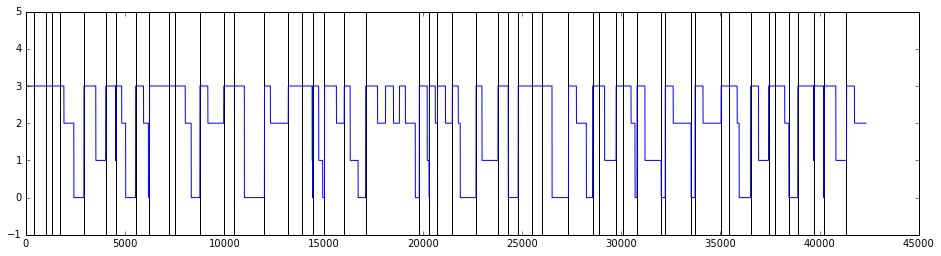

In [80]:
print(np.mean(mean_history[0], axis=0))
plt.figure(figsize=(16, 4))
plt.plot(assignments)
plt.vlines(blow_outs, -1, num_clusters+1)
plt.ylim((-1, num_clusters+1))
plt.show()

In [ ]:
#TODO plot the total average distance to nearest centroid vs. number of centroids